# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

Код для расчёта энтропии:

In [ ]:
def entropy(y):
    
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики точность (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [ ]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler    
scaler= StandardScaler()  
X_train= scaler.fit_transform(X_train)    
X_test= scaler.transform(X_test)

In [ ]:
df= pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


Сделаем разбиение нашего датафрейма.

In [ ]:
# разбиение датафрейма на две части по значению в колонке column_number
def make_split(column_number, t, df):
    left = df[df[df.columns[column_number]] < t]
    right = df[df[df.columns[column_number]] >= t]
    return left, right

# считаем прирост информации по формуле из начала
def calculate_IG(df, sample1, sample2):
    size_R_v = len(df[df.columns[-1]])
    size_R_left = len(sample1[sample1.columns[-1]])
    size_R_right = len(sample2[sample2.columns[-1]])
    IG = entropy(df[df.columns[-1]]) - (size_R_left / size_R_v * entropy(sample1[sample1.columns[-1]]) +
            size_R_right / size_R_v * entropy(sample2[sample2.columns[-1]])
    )
    return IG

# простым перебором выбираем лучшее разбиение
def get_best_split(df):
    best_j, best_t, best_IG = 0, 0.0, 0.0
    for j in range(len(df.columns) - 1):
        for t in df[df.columns[j]]:
            left, right = make_split(j, t, df)
            cur_IG = calculate_IG(df, left, right)
            if cur_IG > best_IG:
                best_j, best_t, best_IG = j, t, cur_IG
    return {'index': best_j, 'value': best_t, 'children': make_split(best_j, best_t, df)}

Строим дерево.

In [ ]:
# возвращаем самый 'популярный прогноз'
def to_terminal(sample):
    return sample[sample.columns[-1]].value_counts().index[0]


def split_node(node, max_depth, min_size, purity, depth):
    left, right = node['children']
    del (node['children'])

    # purity - степень очищенности. Если всего один уникальный элемент - останавливаемся.
    if purity:
        if left.value_counts().size == 1:
            to_terminal(left)
            return
        if right.value_counts().size == 1:
            to_terminal(right)
            return

    # если один из детей пустой - прогнозируем для объединения 
    if left.empty or right.empty:
        node['left'] = node['right'] = to_terminal(pd.concat([left, right]))
        return

    # проверяем условие №1 на максимальную глубину дерева
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return

    # проверяем условие №2 на минимальное количество объектов в листе для левого ребенка
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_best_split(left)
        split_node(node['left'], max_depth, min_size, purity, depth + 1)

    # проверяем условие №2 на минимальное количество объектов в листе для правого ребенка
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_best_split(right)
        split_node(node['right'], max_depth, min_size, purity, depth + 1)

# строим дерево с заданными параметрами
def build_tree(train, max_depth=15, min_size=2, purity=False):
    root = get_best_split(train)
    split_node(root, max_depth, min_size, purity, 1)
    return root

Реализуем процедуру предсказания

In [ ]:
# Делаем предсказаие для конкретной строки из датафрейма
def predict_row(node, row_df):
    if row_df[row_df.columns[node['index']]].iloc[0] < node['value']:
        if isinstance(node['left'], dict):
            return predict_row(node['left'], row_df)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict_row(node['right'], row_df)
        else:
            return node['right']

# Перебираем все строки из тестовой части датафрейма и делаем прогноз
def predict_df(node, df_test):
    y_pred = []
    for i in range(df_test.shape[0]):
        row_df = df_test.iloc[[i]]
        pred_class = predict_row(node, row_df)
        y_pred.append(pred_class)

    return y_pred

Подготовим данные для тестирования и построим дерево.

In [ ]:
train_size = 120
df_train = df.sample(train_size, random_state=42)
df_test = df.drop(df_train.index)

Пронаблюдаем зависимость accuracy от глубины дерева.

In [ ]:
from sklearn.metrics import accuracy_score
accuracies = []
for i_depth in range(1, 10):
  tree = build_tree(df_train, i_depth, 5, True)

  accuracies.append(accuracy_score(df_test[df_test.columns[-1]], predict_df(tree, df_test)))

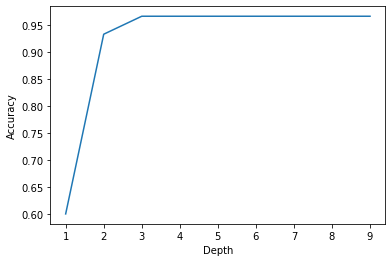

In [ ]:
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.plot(range(1, 10), accuracies)
plt.show()

При глубине дерева равной 3, accuracy достигает своего маскимального значения.

Теперь исследуем, как accuracy зависист от минимального числа объектов в листе.

In [ ]:
from sklearn.metrics import accuracy_score
accuracies = []
for i in range(1, 10):
  tree = build_tree(df_train, 5, i, True)

  accuracies.append(accuracy_score(df_test[df_test.columns[-1]], predict_df(tree, df_test)))

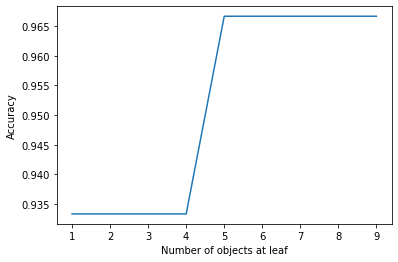

In [ ]:
plt.xlabel("Number of objects at leaf")
plt.ylabel("Accuracy")
plt.plot(range(1, 10), accuracies)
plt.show()

Начиная с 5 объектов в листе accuracy достигает своего маскимального значения.

Проверим теперь работу нашего дерева на ограничениях из условия.

In [ ]:
# первый случай max_depth = 5
tree = build_tree(df_train, 5)
predicted = predict_df(tree, df_test)
print('Accuracy Score With Max Depth=', accuracy_score(df_test[df_test.columns[-1]], predicted) * 100,'%')

Accuracy Score With Max Depth= 93.33333333333333 %


In [ ]:
# второй случай min_size = 5
tree = build_tree(df_train, min_size=5)
predicted = predict_df(tree, df_test)
print('Accuracy Score With Min Size=', accuracy_score(df_test[df_test.columns[-1]], predicted) * 100,'%')

Accuracy Score With Min Size= 96.66666666666667 %


In [ ]:
# третий случай purity=True
tree = build_tree(df_train, purity=True)
predicted = predict_df(tree, df_test)
print('Accuracy Score With purity=', accuracy_score(df_test[df_test.columns[-1]], predicted) * 100,'%')

Accuracy Score With purity= 93.33333333333333 %


Теперь рассмотрим встроенную в sklearn DecisionTreeClassifier, чтобы сравнить результаты

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=5)

In [ ]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=5)

In [ ]:
y_predict=dtc.predict(X_test)

In [ ]:
aсс=accuracy_score(y_predict,y_test)
print('DecisionTreeClassifier Accuracy Score=', aсс * 100,'%')

DecisionTreeClassifier Accuracy Score= 100.0 %


Добавим визуализацию полученного дерева

In [ ]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

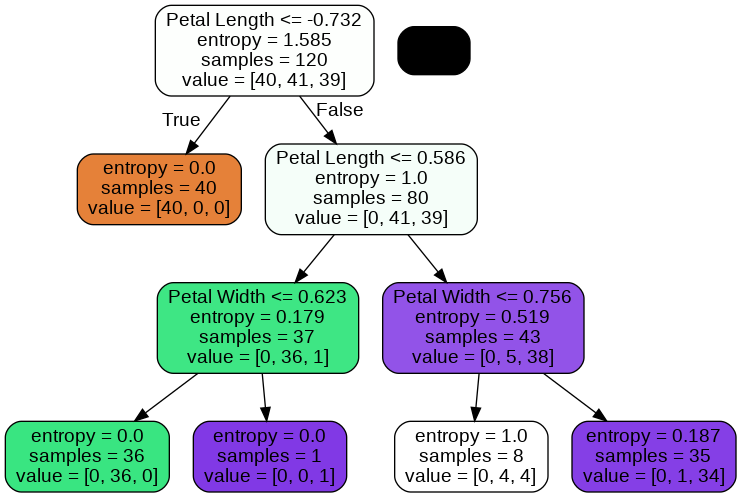

In [ ]:
dot_data=StringIO()
export_graphviz(dtc,out_file=dot_data,feature_names=["Sepal Length","Sepal Width","Petal Length","Petal Width"],filled=True,rounded=True)          
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# Вывод
Встроенный DecisionTreeClassifier имеет 100% значение accuracy, в то время, как самописное дерево имеет значение accuracy равное 96,(6)%. Достигается оно при ограничении в 5 объектов в листе (то есть второе ограничение).

##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import math

In [ ]:
!gdown 1UN97OKuhkci8gBqsO0pF3IYMEs0e60rm

Downloading...
From: https://drive.google.com/uc?id=1UN97OKuhkci8gBqsO0pF3IYMEs0e60rm
To: /content/churn.csv
100% 685k/685k [00:00<00:00, 134MB/s]


In [ ]:
churn = pd.read_csv("/content/churn.csv")

Получим некоторую информацию о загруженном датасете.

In [ ]:
churn.sample(5, random_state=2022)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6487,6488,15574283,Padovano,580,France,Male,31,2,0.00,2,0,1,64014.24,0
8785,8786,15801293,Ni,850,Germany,Male,27,1,101278.25,2,1,1,26265.18,0
7390,7391,15764922,Tu,596,Spain,Male,20,3,187294.46,1,1,0,103456.47,0
7078,7079,15682576,Onyenachiya,763,France,Male,67,1,149436.73,2,0,1,106282.74,0
1230,1231,15742480,Igwebuike,775,Germany,Male,36,2,109949.05,2,0,1,71682.54,0


In [ ]:
churn.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Выяснили, что в датасете присутсвуют как численные, так и категориальные признаки. Кроме того, присутсвуют колонки, которые не несут никакой важной информации (например RowNumber, CustomerId, Surname). Данные необходимо предобработать.

In [ ]:
# Только полезные численные признаки
num_cols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']

# Только полезные категориальные признаки
cat_cols = ['Geography','Gender']

feature_cols = num_cols + cat_cols
target_col = 'Exited'

df = churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# one-hot encoding категориальных признаков
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

# нормализация численных признаков
df[num_cols] = StandardScaler().fit(df[num_cols]).transform(df[num_cols])

X = df.loc[:, df.columns != target_col]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2002)

In [ ]:
class MyRandomForest():
  def __init__(self, N=10, criterion='entropy', max_depth=11, min_samples_leaf=2, max_features='sqrt'):
    self.trees = []

    self.N = N
    self.criterion = criterion
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.max_features = max_features

# будем использовать встроенные в sklearn деревья
  def fit(self, X_train, y_train):
    m = X_train.shape[0]

    for n in range(self.N):
      X_n = X_train.sample(n=m, replace=True) 
      b_n = DecisionTreeClassifier(criterion=self.criterion, 
                                  max_depth=self.max_depth, 
                                  min_samples_leaf=self.min_samples_leaf, 
                                  max_features=self.max_features)
      b_n.fit(X_train, y_train)
      self.trees.append(b_n)


  def _predict_row(self, X_row):
    predictions = []

    for i in range(len(self.trees)):
      predictions.append(self.trees[i].predict(X_row))
    
    predictions_int = []
    for a in predictions:
      predictions_int.append(a[0])

    return max(set(predictions_int), key=predictions_int.count)

  def predict(self, X_test):
    y_pred = []

    for i in range(X_test.shape[0]):
      y_pred.append(self._predict_row(X_test.iloc[[i]]) )
    return y_pred

  def score(self, X_test, y_true):
    y_pred = self.predict(X_test)

    return accuracy_score(y_true, y_pred)

# вычисляет важность признаков
  def count_importance(self, X, y):
    self.fit(X, y)
    length = len(self.trees[0].feature_importances_)
    importances = [0] * length
    for tree in self.trees:
      for i in range(0, length):
        importances[i] += tree.feature_importances_[i]

    for i in range(0, len(importances)):
      importances[i] /= length
    
    return importances

In [ ]:
model = MyRandomForest(N=10)
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.8585

Настроим гиперпараметры

Найдем количество деревьев в лесу, максимальную глубину дерева и количество объектов в листе

In [ ]:
b_max_depth, b_score, b_N, b_leaf  = 1, 0.0, 1, 1
for i_N in range(5, 20, 5):
  for i_max_depth in range(3, 12, 3):
    for i_leaf in range(1, 5, 2):
      model = MyRandomForest(N=i_N, max_depth=i_max_depth,min_samples_leaf=i_leaf)
      model.fit(X_train, y_train)

      scor = model.score(X_test, y_test)

      if scor > b_score:
        b_max_depth, b_score, b_N, b_leaf = i_max_depth, scor, i_N, i_leaf


In [ ]:
b_score, b_N, b_max_depth, b_leaf

(0.864, 15, 9, 1)

In [ ]:
model = MyRandomForest(N=b_N, max_depth=b_max_depth, min_samples_leaf=b_leaf)
model.fit(X_train, y_train)

score_all_features = model.score(X_test, y_test)
score_all_features

0.858

Интерпретация результатов

In [ ]:
model = MyRandomForest(N=b_N, max_depth=b_max_depth, min_samples_leaf=b_leaf)
importances = model.count_importance(X_train, y_train)

In [ ]:
features_importances = []
for i in range(0, len(importances)):
  features_importances.append((X_train.columns[i], importances[i]))

In [ ]:
w = pd.DataFrame(features_importances)
w.columns = ["Feature", "Weight"]
w['Weight']=w['Weight'].abs()
sum = w['Weight'].sum()
w['Weight'] = w['Weight'] / sum

In [ ]:
w.sort_values(by="Weight", ascending=False)

,Feature,Weight
1,Age,0.306478
4,NumOfProducts,0.292839
3,Balance,0.108473
6,IsActiveMember,0.058531
0,CreditScore,0.054886
7,EstimatedSalary,0.051367
9,Geography_Germany,0.042289
2,Tenure,0.026731
12,Gender_Male,0.015136
8,Geography_France,0.013770


В результате исследования признаков, которые вляют на решение людей остаться или уйти, было выяснено, что самым весомым признаком является возраст клиента.